# simple comparisons of bias

In [91]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import pool
import flow
from cascade import paths
from scipy.spatial.distance import cosine
import cascade as cas
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
mice = ['OA27', 'VF226', 'OA67','OA32', 'OA34', 'OA36', 'OA26']
# words = ['bookmarks']
# words.extend(['horrible']*6)
words = ['again']
words.extend(['protecting']*6)

# load in a full size tensor
model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    out = cas.load.load_all_groupday(mouse, word=word, with_model=True, group_by='all100', nan_thresh=0.95)  # return   model, ids, tensor, meta, bhv
    model_list.append(out[0])
    tensor_list.append(out[2])
    id_list.append(out[1])
    bhv_list.append(out[4])
    meta_list.append(cas.utils.add_10stages_to_meta(out[3], simple=False))

Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


In [101]:
meta_list[0].head()

orientation condition initial_condition  \
mouse date     run trial_idx                                            
OA27  170116.0 3   0                    0   neutral           neutral   
                   1                  135     minus             minus   
                   2                  270      plus              plus   
                   3                    0   neutral           neutral   
                   4                  135     minus             minus   

                              trialerror  prev_reward  prev_punish  \
mouse date     run trial_idx                                         
OA27  170116.0 3   0                 3.0        False        False   
                   1                 4.0        False        False   
                   2                 0.0        False        False   
                   3                 3.0        False        False   
                   4                 4.0        False        False   

                              prev_same_plus  prev_same_neutral  \
mouse date     run trial_idx                                      
OA27  170116.0 3   0                   False              False   
                   1                   False              False   
                   2                   False              False   
                   3                   False              False   
                   4                   False              False   

                              prev_same_minus  prev_blank  ...  \
mouse date     run trial_idx                               ...   
OA27  170116.0 3   0                    False       False  ...   
                   1                    False       False  ...   
                   2                    False       False  ...   
                   3                    False       False  ...   
                   4                    False       False  ...   

                             p_go_since_last_go p_reward_since_last_go  \
mouse date     run trial_idx                                             
OA27  170116.0 3   0                        NaN                    NaN   
                   1                        NaN                    NaN   
                   2                        NaN                    NaN   
                   3                        NaN                    NaN   
                   4                        NaN                    NaN   

                             p_initial_plus_since_last_reward  \
mouse date     run trial_idx                                    
OA27  170116.0 3   0                                      NaN   
                   1                                      NaN   
                   2                                      NaN   
                   3                                      NaN   
                   4                                      NaN   

                              p_initial_minus_since_last_reward  \
mouse date     run trial_idx                                      
OA27  170116.0 3   0                                        NaN   
                   1                                        NaN   
                   2                                        NaN   
                   3                                        NaN   
                   4                                        NaN   

                              p_initial_neutral_since_last_reward  \
mouse date     run trial_idx                                        
OA27  170116.0 3   0                                          NaN   
                   1                                          NaN   
                   2                                          NaN   
                   3                                          NaN   
                   4                                          NaN   

                              p_go_since_last_reward  \
mouse date     run trial_idx                           
OA27  170116.0 3   0                             NaN 

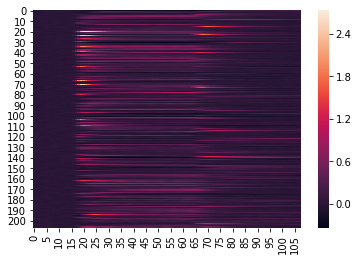

In [104]:
tensor_list[0].shape
for smeta_list[0]['parsed_stage'].unique()
sns.heatmap(np.nanmean(tensor_list[0], axis=2))

In [96]:
# get tensor, metadata, and ids to get things rolling
FC_bias_list = []
FC_5list = []
FC_10list = []
FC_5mat = []
FC_10mat = []
for mouse, ten, met in zip(mice, tensor_list, meta_list):
    
    print('Began {}.'.format(mouse))
    
    # get boolean indexer for period stim is on screen
    stim_window = np.arange(-1, 7, 1/15.5)[0:108]
#     if mouse in ['OA32', 'OA34', 'OA36']:
#         stim_window = (stim_window > 0) & (stim_window < 2)
#     else:
#         stim_window = (stim_window > 0) & (stim_window < 3)
    stim_window = (stim_window > 0) & (stim_window < 1)
        
    # get vector and count of dates for the loop
    date_vec = met.reset_index()['date']
    date_num = len(np.unique(date_vec))
#     date_vec = met['parsed_stage']
#     date_num = len(np.unique(date_vec))
    
    # preallocate tensors
    FC_ten = np.zeros((np.shape(ten)[0], np.shape(ten)[1], date_num))
    QC_ten = np.zeros((np.shape(ten)[0], np.shape(ten)[1], date_num))
    NC_ten = np.zeros((np.shape(ten)[0], np.shape(ten)[1], date_num))
#     FC_ten = np.zeros((np.shape(ten)[0], np.shape(ten)[1], 5))
#     QC_ten = np.zeros((np.shape(ten)[0], np.shape(ten)[1], 5))
#     NC_ten = np.zeros((np.shape(ten)[0], np.shape(ten)[1], 5))
    FC_ten[:] = np.nan
    QC_ten[:] = np.nan
    NC_ten[:] = np.nan

    # preallocate lists
    stage_list = []
    stage10_list = []

    # boolean vecs for each CS
    FC_bool = met['condition'].isin(['plus']).values
    QC_bool = met['condition'].isin(['minus']).values
    NC_bool = met['condition'].isin(['neutral']).values

    # loop through and get mean response of each cell per day for three CSs
    for c, day in enumerate(np.unique(date_vec)):

        # indexing for the day
        day_bool = date_vec.isin([day]).values
        
        stage_list.append(met['parsed_stage'].iloc[day_bool].unique())
        stage10_list.append(met['parsed_10stage'].iloc[day_bool].unique())

        # mean responses
        day_FC = ten[:, :, day_bool & FC_bool]
        day_QC = ten[:, :, day_bool & QC_bool]
        day_NC = ten[:, :, day_bool & NC_bool]
        FC_ten[:, :, c] = np.nanmean(day_FC, axis=2)
        QC_ten[:, :, c] = np.nanmean(day_QC, axis=2)
        NC_ten[:, :, c] = np.nanmean(day_NC, axis=2)

    FC_mean = np.nanmean(FC_ten[:, stim_window, :], axis=1)
    QC_mean = np.nanmean(QC_ten[:, stim_window, :], axis=1)
    NC_mean = np.nanmean(NC_ten[:, stim_window, :], axis=1)

    # do not consider cells that are negative to all three cues
    neg_bool = (FC_mean < 0) & (QC_mean < 0) & (NC_mean < 0)
    FC_mean[FC_mean < 0] = 0
    QC_mean[QC_mean < 0] = 0
    NC_mean[NC_mean < 0] = 0
    FC_mean[neg_bool] = np.nan
    QC_mean[neg_bool] = np.nan
    NC_mean[neg_bool] = np.nan
    
    # get averages across stages and across
    FC_ten5 = np.zeros((np.shape(ten)[0], 5))
    QC_ten5 = np.zeros((np.shape(ten)[0], 5))
    NC_ten5 = np.zeros((np.shape(ten)[0], 5))
    FC_ten5[:] = np.nan
    QC_ten5[:] = np.nan
    NC_ten5[:] = np.nan
    if mouse in ['OA32', 'OA34', 'OA36']:
        shifter = 1
    else:
        shifter = 0
    for ci, si in enumerate(np.unique(stage_list)):
        stage_bool = np.isin(np.array(stage_list), si).flatten()
        FC_ten5[:,ci+shifter] = np.nanmean(FC_mean[:,stage_bool], axis=1)
        QC_ten5[:,ci+shifter] = np.nanmean(QC_mean[:,stage_bool], axis=1)
        NC_ten5[:,ci+shifter] = np.nanmean(NC_mean[:,stage_bool], axis=1)
    FC_stage5_bias = FC_ten5/np.nansum(np.concatenate([FC_ten5[:,:,None], NC_ten5[:,:,None], QC_ten5[:,:,None]],axis=2),axis=2)
                
    FC_ten10 = np.zeros((np.shape(ten)[0], 10))
    QC_ten10 = np.zeros((np.shape(ten)[0], 10))
    NC_ten10 = np.zeros((np.shape(ten)[0], 10))
    FC_ten10[:] = np.nan
    QC_ten10[:] = np.nan
    NC_ten10[:] = np.nan
    if mouse in ['OA32', 'OA34', 'OA36']:
        shifter = 2
    else:
        shifter = 0
    for ci, si in enumerate(np.unique(stage10_list)):
        stage_bool = np.isin(np.array(stage10_list), si).flatten()
        FC_ten10[:,ci+shifter] = np.nanmean(FC_mean[:,stage_bool], axis=1)
        QC_ten10[:,ci+shifter] = np.nanmean(QC_mean[:,stage_bool], axis=1)
        NC_ten10[:,ci+shifter] = np.nanmean(NC_mean[:,stage_bool], axis=1)
    FC_stage10_bias = FC_ten10/np.nansum(np.concatenate([FC_ten10[:,:,None], NC_ten10[:,:,None], QC_ten10[:,:,None]],axis=2),axis=2)
    
    FC_5mat.append(FC_stage5_bias)
    FC_10mat.append(FC_stage10_bias)

    # calculate bias
    FC_bias = FC_mean/np.nansum(np.concatenate([FC_mean[:,:,None], QC_mean[:,:,None], NC_mean[:,:,None]],axis=2),axis=2)
    FC_bias_list.append(FC_bias)
    FC_5list.append(stage_list)
    FC_10list.append(stage10_list)
    
    print('Done {}.\n'.format(mouse))

Began OA27.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarn

Done OA27.

Began VF226.
Done VF226.

Began OA67.
Done OA67.

Began OA32.
Done OA32.

Began OA34.
Done OA34.

Began OA36.
Done OA36.

Began OA26.
Done OA26.



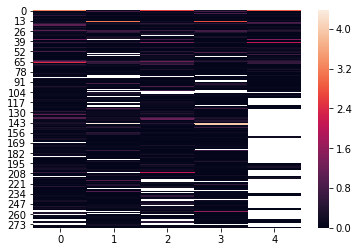

In [98]:
sns.heatmap(FC_ten5)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


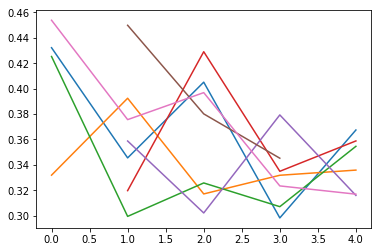

In [100]:
for i in range(len(FC_bias_list)):
#     plt.plot(np.nanmean(FC_bias_list[i], axis=0))
    plt.plot(np.nanmean(FC_5mat[i], axis=0))

In [78]:
df_list = []
for i in range(len(FC_bias_list)):
    
    data = {
        'mouse': [mouse]*len(FC_bias_list[i]),
        'cell': np.arange(len(FC_bias_list[i])),
        'FC_bias': FC_bias_list[i],
        'stage5': FC_5list[i],
        'stage10': FC_10list[i],
    }
    
    mouse_df = pd.DataFrame(data=data)
    df_list.append(mouse_df)
full_df = pd.concat(df_list, axis=0)


ValueError: arrays must all be same length